# CICIDS2017 - LSTM Multiclass Classifier

### Concatenate the dataset csv's

In [1]:
import pandas as pd
import os

def concat_csv_files(folder_path):
    """
    Concatenates all CSV files within a specified folder into a single DataFrame.

    Args:
        folder_path: The path to the folder containing the CSV files.

    Returns:
        A pandas DataFrame containing the concatenated data, or None if no CSV 
        files are found or an error occurs.
    """
    all_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    if not all_files:
        print("No CSV files found in the specified folder.")
        return None
    try:
        df_list = []
        for filename in all_files:
          file_path = os.path.join(folder_path, filename)
          df = pd.read_csv(file_path, low_memory=False)
          df_list.append(df)
        combined_df = pd.concat(df_list, axis=0, ignore_index=True)
        return combined_df
    except Exception as e:
        print(f"An error occurred: {e}")
        return None


folder_path = "CIC-IDS2017"
combined_dataframe = concat_csv_files(folder_path)

if combined_dataframe is not None:
    print("CSV files concatenated successfully.")
    combined_dataframe.to_csv("cicids2017.csv", index=False)

CSV files concatenated successfully.


## Preprocessing

### Feature reduction

According to some literature the features to drop (because they are redundant or meaningless) are
six, namely, “Flow ID”, “Source IP ”, “Source Port”, “Destination IP”, “Protocol”, and “Time stamp”, hence reducing its feature dimension to 77. (This features were already removed from the downloaded dataset).

### Feature selection
In this section I analyse the motives that should imply why a columns should be removed from the dataset.

#### Features to consider removing

##### Highly Correlated Features:
+ Features that are highly correlated (e.g., Fwd Packet Length Max and Fwd Packet Length Mean) may provide redundant information. The usage of a correlation matrix to identify these is a good method.

##### Statistical Aggregates:
+ Detailed statistics (mean, max, min, std) for packet lengths, I considered keeping only a few representative aggregates. For example:
  + Keeping Mean or Std and drop Max and Min if their patterns do not add unique predictive power.

##### Low Variance Features:
+ Features that show little or no variation across the dataset do not contribute to distinguishing between classes. 
  + Example: Flags like Fwd PSH Flags, Bwd URG Flags, CWE Flag Count.

In the next code block I do some feature selection in a simple way, but in the section "More Feature Selection" a deeper analysis towards this goal in made.

#### Dataset cleaning

Here we make all features to be greater or equal than 0, identify and remove the columns that have zero variance (feature selection due to low variance in this features as explained previously), drop the rows that have infinite and nan values, drop the duplicates and finally we drop the columns we identical values (feature selection due to a great correlation between this features as explained previously).

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations, product

def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df

# Load CIC-IDS2017 dataset
df = pd.read_csv("cicids2017.csv")
df = clean_df(df)
df['Label'].value_counts()
df.to_csv('step1_cleaned_dataset_cicids2017.csv', index=False)

dataset shape (2830743, 79)
zero variance columns ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] dropped
shape after removing zero variance columns: (2830743, 71)
2867 rows dropped
shape after removing nan: (2827876, 71)
shape after dropping duplicates: (2520798, 71)
columns which have identical values [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')] dropped
shape after removing identical value columns: (2520798, 66)


In [5]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

Here we can see that some of the labels have non readable characters, so we will change their value.

In [2]:
### rename Labels that contain non-printable characters 
print("Before rename...")
print(df.loc[:,"Label"].unique())

df.loc[:,"Label"].replace({"Web Attack � XSS" : "XSS", "Web Attack � Sql Injection": "Sql Injection", "Web Attack � Brute Force": "Brute Force"}, inplace=True)
print("After rename..")
print(df.loc[:,"Label"].unique())

## remove trailing && leading spaces from all the labels
rename_cols = lambda col_lbl: col_lbl.strip()
df.rename(rename_cols, axis=1, inplace=True, errors="raise")

df.to_csv('step2_labels_renamed_cicids2017.csv')

df['Label'].value_counts()

Before rename...
['BENIGN' 'PortScan' 'DDoS' 'FTP-Patator' 'SSH-Patator' 'Infiltration'
 'Bot' 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


/tmp/ipykernel_139288/2349323896.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.loc[:,"Label"].replace({"Web Attack � XSS" : "XSS", "Web Attack � Sql Injection": "Sql Injection", "Web Attack � Brute Force": "Brute Force"}, inplace=True)


After rename..
['BENIGN' 'PortScan' 'DDoS' 'FTP-Patator' 'SSH-Patator' 'Infiltration'
 'Bot' 'Brute Force' 'XSS' 'Sql Injection' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


Label
BENIGN              2095057
DoS Hulk             172846
DDoS                 128014
PortScan              90694
DoS GoldenEye         10286
FTP-Patator            5931
DoS slowloris          5385
DoS Slowhttptest       5228
SSH-Patator            3219
Bot                    1948
Brute Force            1470
XSS                     652
Infiltration             36
Sql Injection            21
Heartbleed               11
Name: count, dtype: int64

#### Data visualization

Data visualization can help us identify what features are more likelly to make the difference in the predicting task.

In [3]:
# temporarily add new column to distinguish traffic type between Normal / Attack 

trafic_type = df.loc[:, "Label"].map(lambda lbl: "Normal" if lbl == "BENIGN" else "Attack")
trafic_type.name = "Traffic type"
df.loc[:, trafic_type.name] = trafic_type

print(df.shape)

(2520798, 67)


#### Plot distribution of Normal traffic and Attacks

/tmp/ipykernel_139288/168008765.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Traffic type", data=df, palette=["g","r"])


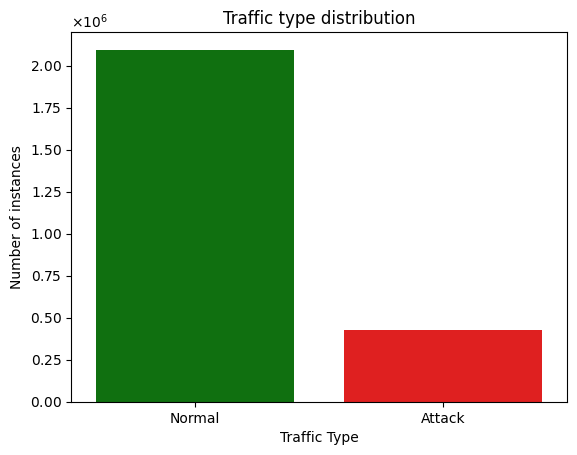

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)

sns.countplot(x="Traffic type", data=df, palette=["g","r"])

plt.title("Traffic type distribution")
plt.xlabel("Traffic Type")
plt.ylabel("Number of instances")
# plt.savefig("distribution1.png", dpi=200, format='png')
plt.show()

As we can see the dataset is heavily imbalanced, the Normal traffic outweights the Malicious traffic in great manner. With a dataset like this the model might get biased one class, to avoid this we can under-sample or over-sample.

Do to hardware requisitions when training a model with a big dataset, I will Under-sample (this will disminuish the number of observations in the dataset) in this case, but keeping in mind that Over-sampling might be the best option in this kind of task.

In [11]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=10, sampling_strategy=0.85) # equals traffic unless ratio is specified

#df.drop(["Traffic type"], axis=1, inplace=True) # temporarily remove the categorical column for underSampling

df_data_res, traffic_type_res = rus.fit_resample(df, trafic_type)

dfv2 = df_data_res.join(traffic_type_res, how="inner")

dfv2.shape

(926612, 67)

/tmp/ipykernel_139288/2847398911.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Traffic type", data=dfv2, order=["Normal", "Attack"],  palette=["g","r"])


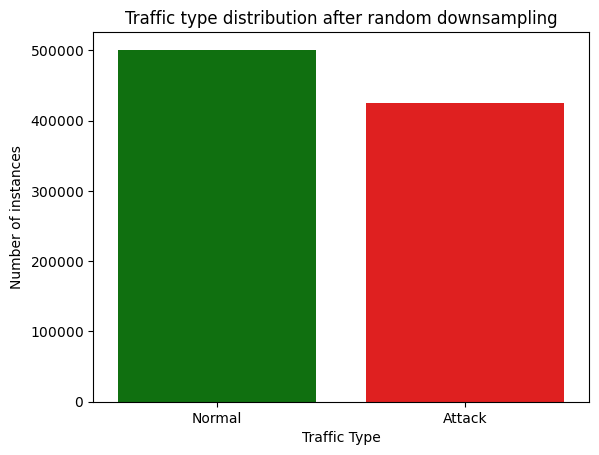

In [13]:
### show distribution chart after downsampling Normal traffic 

plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)  # change def ScalarFormatter
sns.countplot(x="Traffic type", data=dfv2, order=["Normal", "Attack"],  palette=["g","r"])

#plt.title("Traffic type distribution in whole dataset after random downsampling")
plt.title("Traffic type distribution after random downsampling")
plt.xlabel("Traffic Type")
plt.ylabel("Number of instances")
# plt.savefig("distribution2.png", dpi=200, format='png')
plt.show()

### More Feature Selection

In [14]:
labels = dfv2.loc[:, "Label"] # labels column
features = dfv2.iloc[:, :-2] # removing the "Label" and "Traffic type" columns 

features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 926612 entries, 1463 to 1059533
Data columns (total 65 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             926612 non-null  int64  
 1   Flow Duration                926612 non-null  int64  
 2   Total Fwd Packets            926612 non-null  int64  
 3   Total Backward Packets       926612 non-null  int64  
 4   Total Length of Fwd Packets  926612 non-null  int64  
 5   Total Length of Bwd Packets  926612 non-null  int64  
 6   Fwd Packet Length Max        926612 non-null  int64  
 7   Fwd Packet Length Min        926612 non-null  int64  
 8   Fwd Packet Length Mean       926612 non-null  float64
 9   Fwd Packet Length Std        926612 non-null  float64
 10  Bwd Packet Length Max        926612 non-null  int64  
 11  Bwd Packet Length Min        926612 non-null  int64  
 12  Bwd Packet Length Mean       926612 non-null  float64
 13  

I'll use RandomForestClassifier to check the attributes importance.

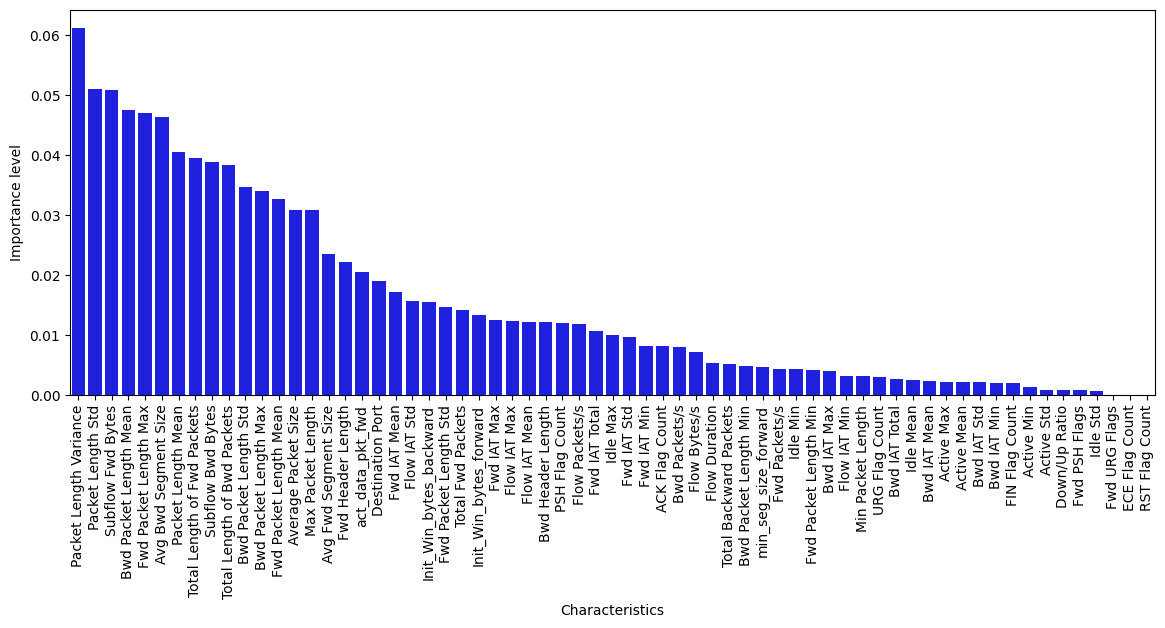

In [15]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=10, n_jobs=-1) # 100 trees in forest

# fit random forest classifier on the dataset
rfc.fit(features, labels)

score = np.round(rfc.feature_importances_,5)

importances = pd.DataFrame({'Characteristics': features.columns,'Importance level': score})
importances = importances.sort_values('Importance level',ascending=False).set_index('Characteristics')

# plot importances
sns.barplot(x=importances.index, y="Importance level", data=importances, color="b")
plt.xticks(rotation="vertical")
plt.gcf().set_size_inches(14,5)
# plt.savefig("importances.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.2)
plt.show()



Here I will create a threshold that if the importance score is smaller the column in question will not be considered.

In [16]:
threshold = 0.001 # importance threshold

bl_thresh = importances.loc[importances["Importance level"] < threshold]
print("There are {} features to delete, as they are below the chosen threshold".format(bl_thresh.shape[0]))
print("These features are the following:")
feats_to_del = [feat for feat in bl_thresh.index]
print("\n".join(feats_to_del))

# removing these not important features 
dfv2.drop(columns=feats_to_del, inplace=True) # dropping columns

dfv2

There are 7 features to delete, as they are below the chosen threshold
These features are the following:
Active Std
Down/Up Ratio
Fwd PSH Flags
Idle Std
Fwd URG Flags
ECE Flag Count
RST Flag Count


Destination Port  Flow Duration  Total Fwd Packets  \
1463                   80        5021059                  6   
1467                   80             70                  1   
1468                   80        5024211                  6   
1480                   80             52                  1   
1511                   80        5386396                  3   
...                   ...            ...                ...   
701043                 53          84655                  2   
1403497               443         179211                 10   
569087              52297              3                  2   
2608095             62044             50                  1   
1059533               443          23913                  2   

         Total Backward Packets  Total Length of Fwd Packets  \
1463                          5                          703   
1467                          1                            0   
1468                          5                          703   
1480                          1                            0   
1511                          1                            0   
...                         ...                          ...   
701043                        2                           82   
1403497                       7                          592   
569087                        0                            0   
2608095                       1                            0   
1059533                       0                           12   

         Total Length of Bwd Packets  Fwd Packet Length Max  \
1463                            1414                    356   
1467                               0                      0   
1468                            1414                    356   
1480                               0                      0   
1511                               0                      0   
...                              ...                    ...   
701043                           430                     41   
1403497                         3843                    202   
569087                             0                      0   
2608095                            0                      0   
1059533                            0                      6   

         Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
1463                         0              117.166667             181.536131   
1467                         0                0.000000               0.000000   
1468                         0              117.166667             181.536131   
1480                         0                0.000000               0.000000   
1511                         0                0.000000               0.000000   
...                        ...                     ...                    ...   
701043                      41               41.000000               0.000000   
1403497                      0               59.200000              75.589241   
569087                       0                0.000000               0.000000   
2608095                      0                0.000000               0.000000   
1059533                      6                6.000000               0.000000   

         ...  act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Max  \
1463     ...                 2                    32          0.0           0   
1467     ...                 0                    32          0.0           0   
1468     ...                 2                    32          0.0           0   
1480     ...                 0                    32          0.0           0   
1511     ...                 0                    32          0.0           0   
...      ...               ...                   ...          ...         ...   
701043   ...                 1                    32          0.0           0   
1403497  ...                 9                    20          0.0           0   
569087   ...            

#### Detect higly correlated pairs visually

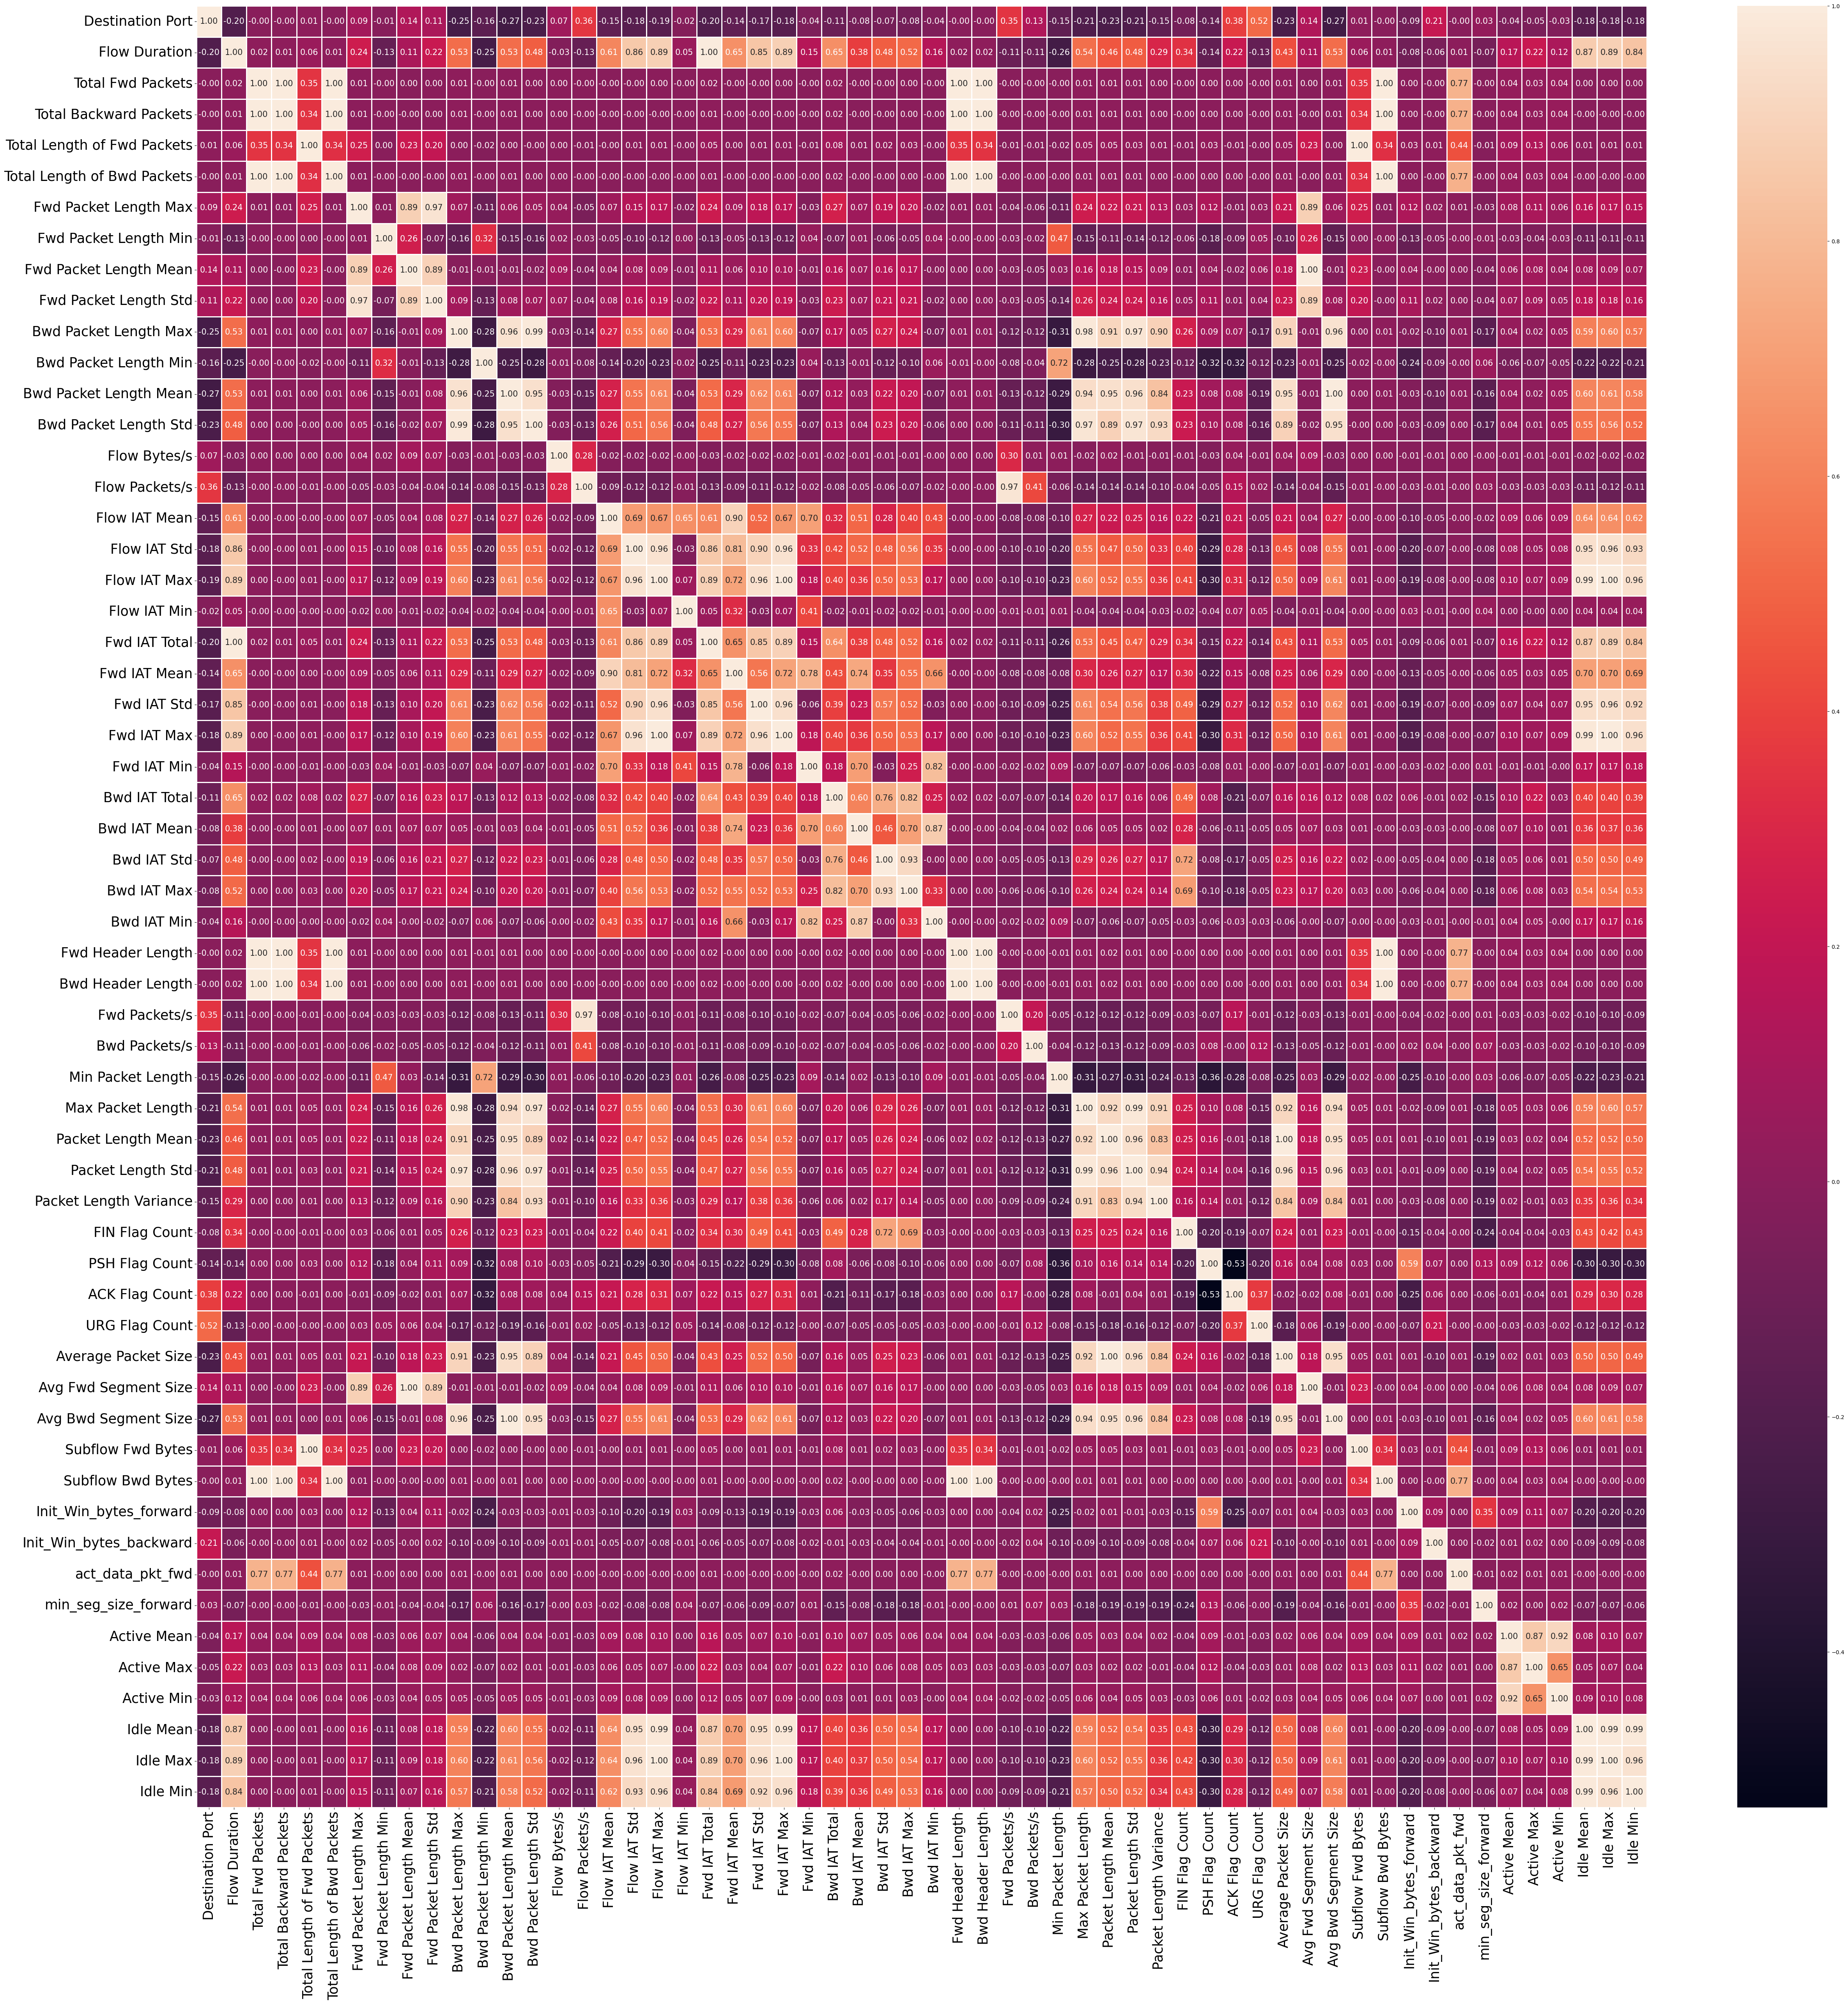

In [18]:
df_correlation_matrix = dfv2.iloc[:, :-2].corr() # removing the "Label" and "Traffic type" columns 

plt.gcf().set_size_inches(60, 60)
hm = sns.heatmap(df_correlation_matrix, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")
hm.set_yticklabels(hm.get_ymajorticklabels(), fontsize = 25)
hm.set_xticklabels(hm.get_xmajorticklabels(), fontsize = 25)
# plt.savefig("corr_heatmap.png", dpi=200, format='png', bbox_inches = "tight", pad_inches=0.4)
plt.show()

In [19]:
df_correlation_matrix

Destination Port  Flow Duration  \
Destination Port                     1.000000      -0.204427   
Flow Duration                       -0.204427       1.000000   
Total Fwd Packets                   -0.003841       0.015433   
Total Backward Packets              -0.003453       0.013983   
Total Length of Fwd Packets          0.013678       0.055025   
Total Length of Bwd Packets         -0.002905       0.012295   
Fwd Packet Length Max                0.085821       0.241454   
Fwd Packet Length Min               -0.011046      -0.130686   
Fwd Packet Length Mean               0.136699       0.112446   
Fwd Packet Length Std                0.110144       0.223624   
Bwd Packet Length Max               -0.248088       0.530762   
Bwd Packet Length Min               -0.164057      -0.250396   
Bwd Packet Length Mean              -0.267713       0.529533   
Bwd Packet Length Std               -0.232986       0.481735   
Flow Bytes/s                         0.073959      -0.026907   
Flow Packets/s                       0.355901      -0.128973   
Flow IAT Mean                       -0.145389       0.613380   
Flow IAT Std                        -0.184754       0.861138   
Flow IAT Max                        -0.185177       0.891442   
Flow IAT Min                        -0.021681       0.054473   
Fwd IAT Total                       -0.203418       0.999201   
Fwd IAT Mean                        -0.143573       0.652477   
Fwd IAT Std                         -0.173573       0.849845   
Fwd IAT Max                         -0.184273       0.891368   
Fwd IAT Min                         -0.042372       0.153177   
Bwd IAT Total                       -0.107914       0.645455   
Bwd IAT Mean                        -0.075137       0.379587   
Bwd IAT Std                         -0.072825       0.484213   
Bwd IAT Max                         -0.080639       0.520767   
Bwd IAT Min                         -0.040569       0.155749   
Fwd Header Length                   -0.004541       0.017291   
Bwd Header Length                   -0.004198       0.015965   
Fwd Packets/s                        0.350141      -0.112228   
Bwd Packets/s                        0.134405      -0.108657   
Min Packet Length                   -0.153964      -0.259741   
Max Packet Length                   -0.211015       0.537923   
Packet Length Mean                  -0.228432       0.457410   
Packet Length Std                   -0.209389       0.477547   
Packet Length Variance              -0.154852       0.290522   
FIN Flag Count                      -0.081701       0.339765   
PSH Flag Count                      -0.142458      -0.143245   
ACK Flag Count                       0.378525       0.218196   
URG Flag Count                       0.518524      -0.134210   
Average Packet Size                 -0.227399       0.434973   
Avg Fwd Segment Size                 0.136699       0.112446   
Avg Bwd Segment Size                -0.267713       0.529533   
Subflow Fwd Bytes                    0.013678       0.055025   
Subflow Bwd Bytes                   -0.002905       0.012294   
Init_Win_bytes_forward              -0.085699      -0.084825   
Init_Win_bytes_backward              0.210036      -0.057248   
act_data_pkt_fwd                    -0.002837       0.010684   
min_seg_size_forward                 0.031690      -0.071333   
Active Mean                         -0.042166       0.165471   
Active Max                          -0.050577       0.222660   
Active Min                          -0.033312       0.119656   
Idle Mean                           -0.180599       0.873041   
Idle Max                            -0.180509       0.889041   
Idle Min                            -0.177225       0.839482   

                             Total Fwd Packets  Total Backward Packets  \
Destination Port                     -0.003841               -0.003453   
Flow Duration                         0.015433                0.013983   
Total Fwd Packets             

Listing of highly correlated pairs:

In [21]:
def srt_corr(mtrx):
    # Unstack the correlation matrix
    corr_ustack = mtrx.unstack().abs()
    # Remove self-correlations by filtering out entries where the row and column indices are the same
    corr_ustack = corr_ustack[corr_ustack.index.get_level_values(0) != corr_ustack.index.get_level_values(1)]
    # Sort the correlations
    corr_srted = corr_ustack.sort_values(ascending=False)
    
    return corr_srted

srt_corr(df_correlation_matrix)

Avg Fwd Segment Size         Fwd Packet Length Mean         1.000000
Fwd Packet Length Mean       Avg Fwd Segment Size           1.000000
Subflow Fwd Bytes            Total Length of Fwd Packets    1.000000
Total Length of Fwd Packets  Subflow Fwd Bytes              1.000000
Avg Bwd Segment Size         Bwd Packet Length Mean         1.000000
                                                              ...   
act_data_pkt_fwd             Bwd IAT Std                    0.000058
Total Length of Bwd Packets  Flow IAT Max                   0.000012
Flow IAT Max                 Total Length of Bwd Packets    0.000012
                             Subflow Bwd Bytes              0.000012
Subflow Bwd Bytes            Flow IAT Max                   0.000012
Length: 3306, dtype: float64

In [ ]:
from collections import OrderedDict
thres_corr = 0.95
epoch=0
highly_corr = {"dummy": "dummy"}
feats_deled = []

all_data_corr_mtrx2 = df_correlation_matrix.copy()
def add_to_dct(l, ft, ft2):
    try:
        l[ft].append(ft2)
    except KeyError:
        l[ft] = [ft2]

get_imp = lambda feat: importances.loc[feat][0]
srt_key = lambda elem: get_imp(elem[0])  # gets importance of first element

def what_to_del(dct_srt):    
    to_del = []  # least important feature
    for k, val in dct_srt.items():
        # get all indexes lower than current k
        feats_lw_imp = importances[importances.index.slice_indexer(k)].index
        if set(val) - set(feats_lw_imp):  # feature k creates a correlation pair w/ feature of higher importance --- delete feat k
            if k not in to_del: to_del.append(k)
        else:  # feature k creates a correlation pair w/ features of lower importance --- delete one w/ lowest importance 
            for ft in feats_lw_imp[::-1]:  # searching from least important
                if ft in val and ft not in to_del:
                    to_del.append(ft)
                    break  # deleting first foundend feature of lowest possible importance
    return to_del
        
while highly_corr:
    count = 0
    highly_corr.clear()
    for feats, val in srt_corr(all_data_corr_mtrx2).items():
        if val > thres_corr and feats[0] != feats[1]:
            count += 1
            add_to_dct(highly_corr, feats[0], feats[1])
    if not highly_corr: break  # no more highly correlated pairs
    highly_corr_srt = OrderedDict(sorted(highly_corr.items(), key=srt_key))  # sorted based on importance

    to_del = what_to_del(highly_corr_srt)
    feats_deled += to_del
    epoch +=1 # first epoch will be 1 not 0! 
    print("There are {} higly correlated pairs in {} iteration".format(count, epoch))
    all_data_corr_mtrx2.drop(to_del, axis=1, inplace=True)
    all_data_corr_mtrx2.drop(to_del, axis=0, inplace=True)  # need to remove the feat from both cols and index

print("Deleting: {} feature".format(len(feats_deled)))
print("Finally deleted:\n"+ "\n".join(feats_deled))

There are 110 higly correlated pairs in 1 iteration
Deleting: 23 feature
Finally deleted:
Idle Mean
Idle Min
Fwd Packets/s
Total Backward Packets
Flow Duration
Fwd IAT Std
Idle Max
Bwd Header Length
Flow IAT Max
Fwd IAT Max
Total Fwd Packets
Fwd Packet Length Std
Fwd Header Length
Avg Fwd Segment Size
Max Packet Length
Average Packet Size
Bwd Packet Length Max
Bwd Packet Length Std
Total Length of Bwd Packets
Total Length of Fwd Packets
Packet Length Mean
Avg Bwd Segment Size
Bwd Packet Length Mean


/tmp/ipykernel_139288/2491038987.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  get_imp = lambda feat: importances.loc[feat][0]


#### Plotting correlation matrix heatmap after removing highly correlated pairs

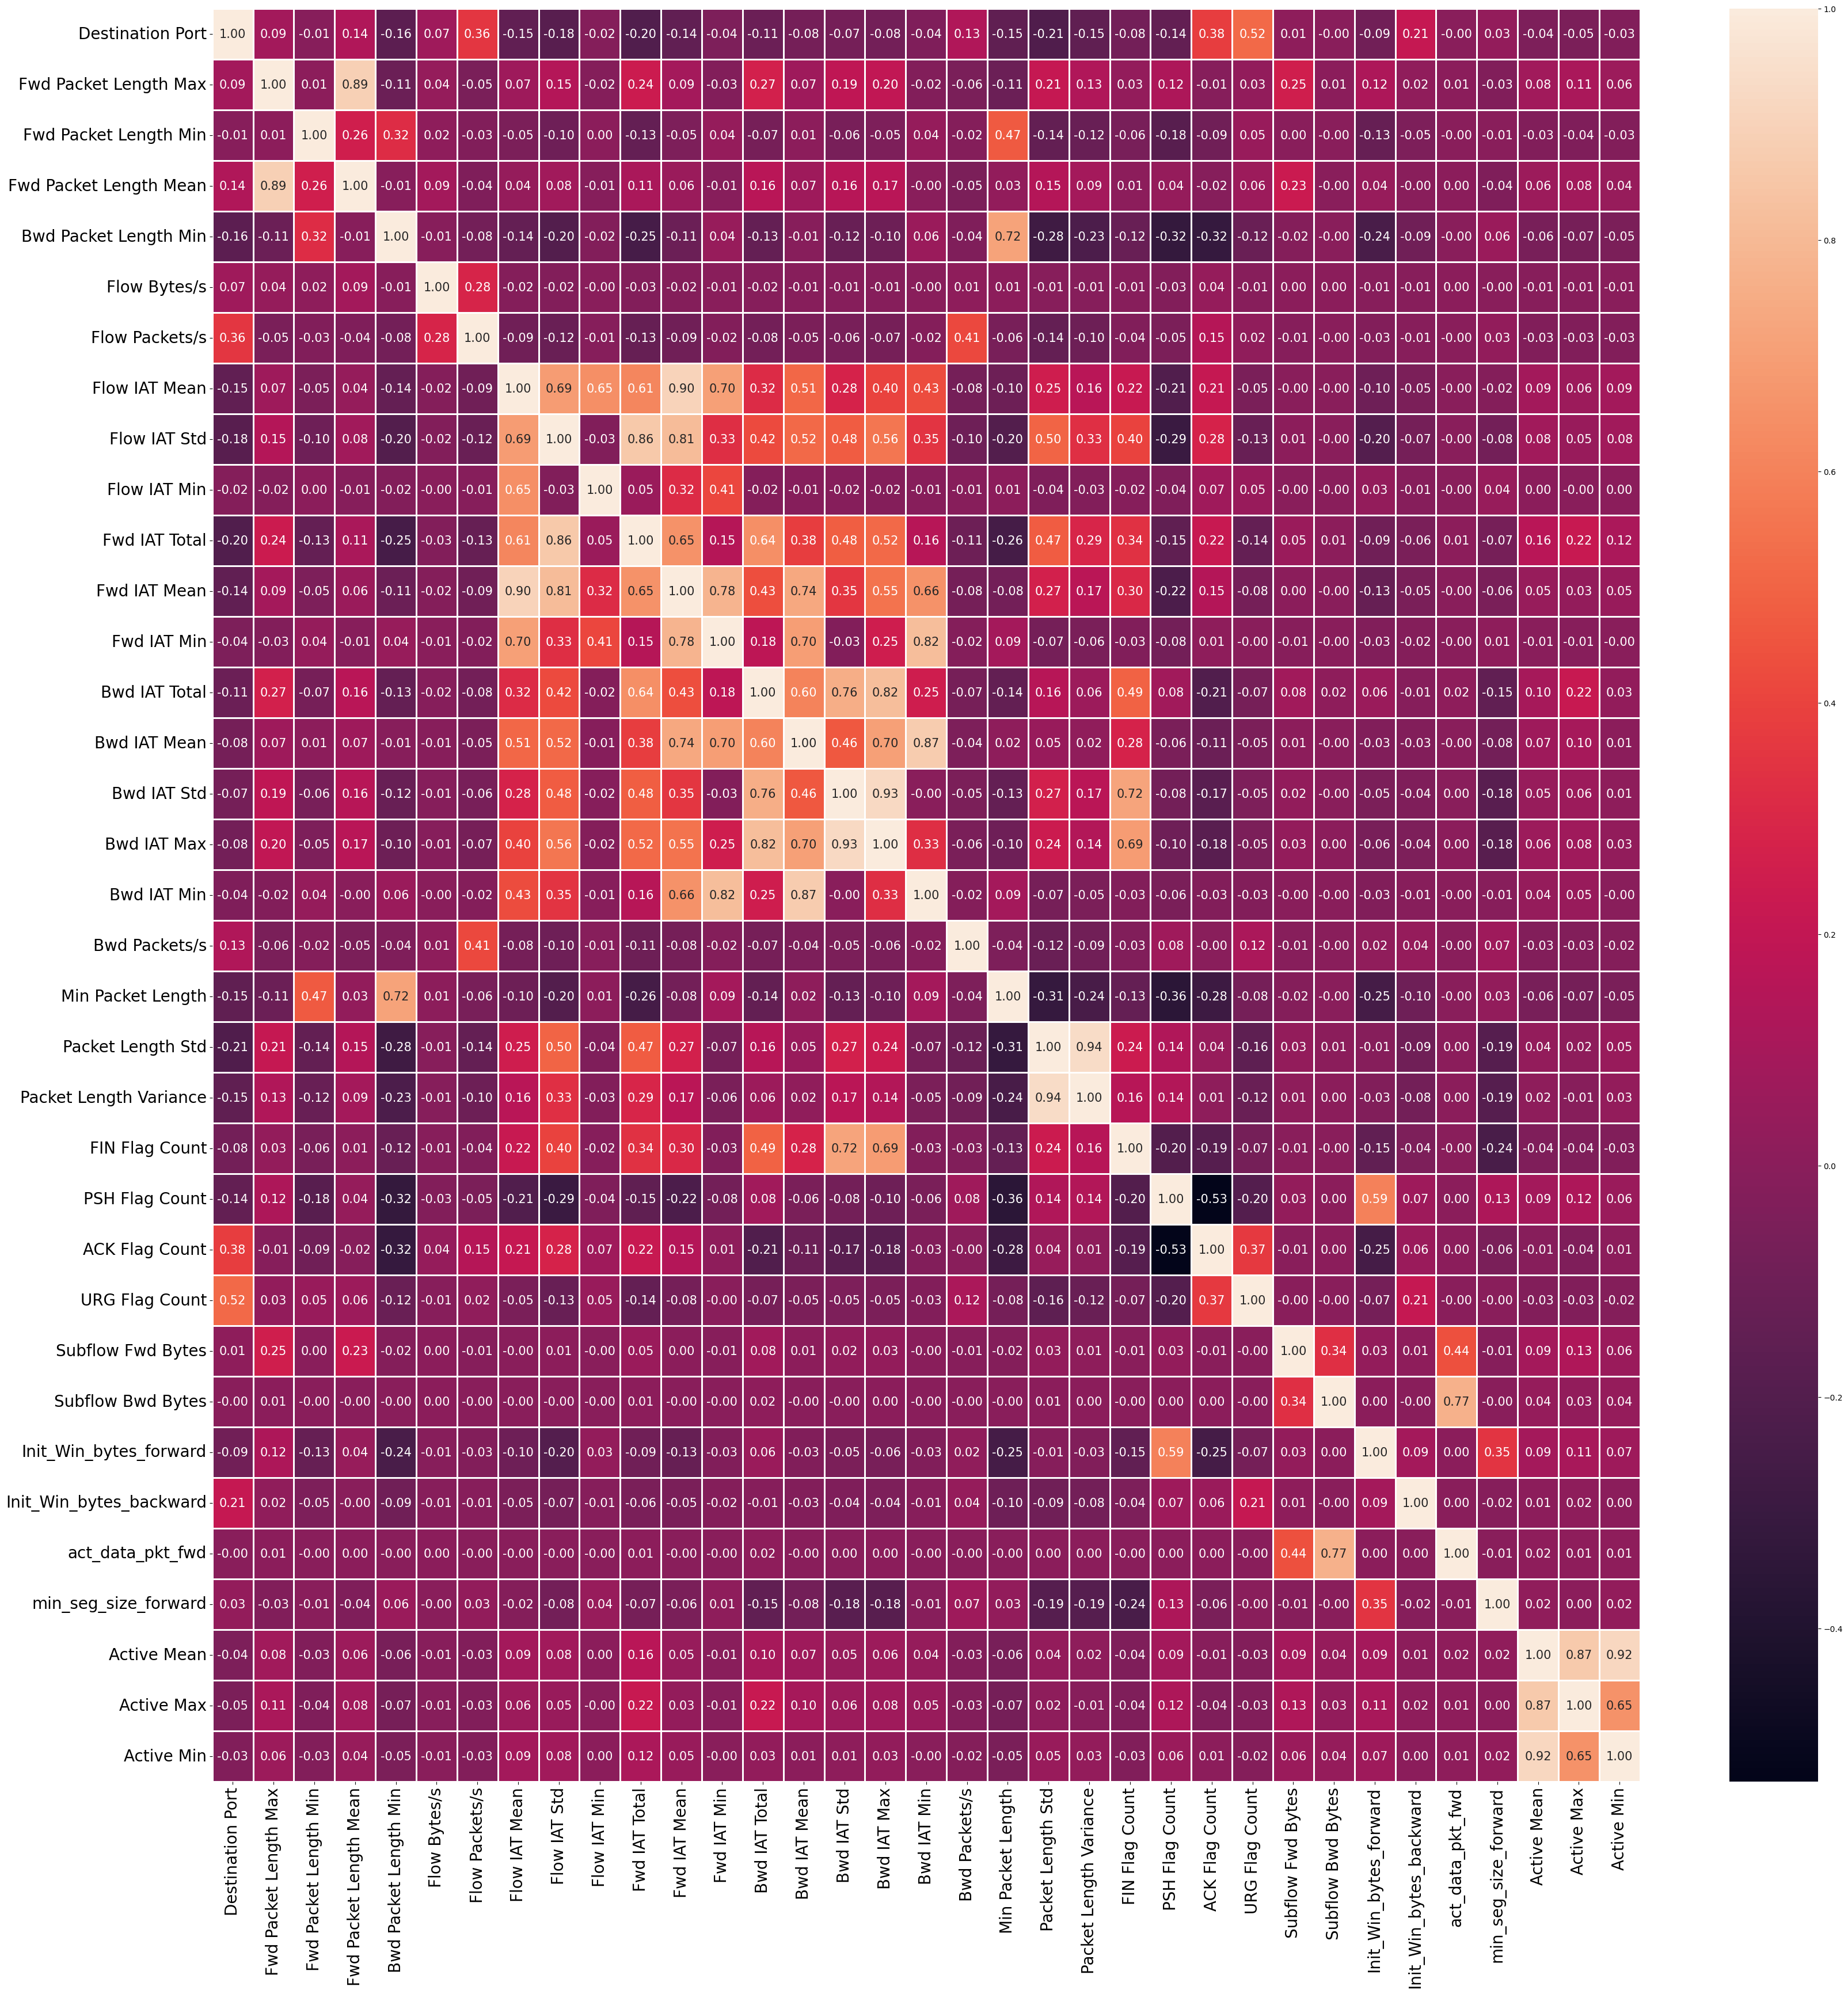

In [26]:
plt.gcf().set_size_inches(40, 40)

# Plot the heatmap
hm2 = sns.heatmap(all_data_corr_mtrx2, annot=True, linewidths=.8, annot_kws={"fontsize": 15}, fmt=".2f")

# Adjust tick labels directly from hm2
hm2.set_yticklabels(hm2.get_yticklabels(), fontsize=20)
hm2.set_xticklabels(hm2.get_xticklabels(), fontsize=20)

# Save and show the plot
# plt.savefig("corr_heatmap2.png", dpi=200, format='png', bbox_inches="tight", pad_inches=0.4)
plt.show()

In [28]:
dfv3 = dfv2.copy()

dfv3.drop(feats_deled, axis=1, inplace=True)

dfv3_cp = dfv3.copy()

dfv3.to_csv('feature_selected_cicids2017.csv')

dfv3

Destination Port  Fwd Packet Length Max  Fwd Packet Length Min  \
1463                   80                    356                      0   
1467                   80                      0                      0   
1468                   80                    356                      0   
1480                   80                      0                      0   
1511                   80                      0                      0   
...                   ...                    ...                    ...   
701043                 53                     41                     41   
1403497               443                    202                      0   
569087              52297                      0                      0   
2608095             62044                      0                      0   
1059533               443                      6                      6   

         Fwd Packet Length Mean  Bwd Packet Length Min  Flow Bytes/s  \
1463                 117.166667                      0    421.624203   
1467                   0.000000                      0      0.000000   
1468                 117.166667                      0    421.359692   
1480                   0.000000                      0      0.000000   
1511                   0.000000                      0      0.000000   
...                         ...                    ...           ...   
701043                41.000000                    215   6048.077491   
1403497               59.200000                      0  24747.364840   
569087                 0.000000                      0      0.000000   
2608095                0.000000                      0      0.000000   
1059533                6.000000                      0    501.819094   

         Flow Packets/s  Flow IAT Mean  Flow IAT Std  Flow IAT Min  ...  \
1463           2.190773   5.021059e+05  1.568379e+06            19  ...   
1467       28571.428570   7.000000e+01  0.000000e+00            70  ...   
1468           2.189398   5.024211e+05  1.567647e+06            19  ...   
1480       38461.538460   5.200000e+01  0.000000e+00            52  ...   
1511           0.742612   1.795465e+06  3.108999e+06           130  ...   
...                 ...            ...           ...           ...  ...   
701043        47.250605   2.821833e+04  4.883142e+04             3  ...   
1403497       94.860249   1.120069e+04  1.752723e+04             3  ...   
569087    666666.666700   3.000000e+00  0.000000e+00             3  ...   
2608095    40000.000000   5.000000e+01  0.000000e+00            50  ...   
1059533       83.636516   2.391300e+04  0.000000e+00         23913  ...   

         Subflow Bwd Bytes  Init_Win_bytes_forward  Init_Win_bytes_backward  \
1463                  1414                   29200                      243   
1467                     0                     253                      243   
1468                  1414                   29200                      243   
1480                     0                     253                      243   
1511                     0                   29200                    28960   
...                    ...                     ...                      ...   
701043                 430                       0                        0   
1403497               3843                    8192                      119   
569087                   0                     351                        0   
2608095                  0                     349                    32832   
1059533                  0                     256                        0   

         act_data_pkt_fwd  min_seg_size_forward  Active Mean  Active Max  \
1463                    2                    32          0.0           0   
1467                    0                    32          0.0           0   
1468                    2                    32          0.0           0   
1480                    0                    32          0.0           0   
1511         

/tmp/ipykernel_66746/2033664166.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subsample_df = dfv3.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)


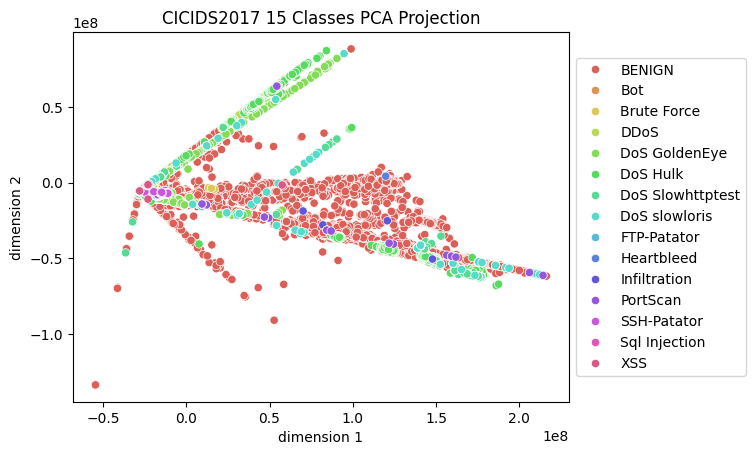

In [ ]:
from sklearn.decomposition import PCA
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# dfv3 = pd.read_csv('feature_selected_cicids2017.csv')

subsample_df = dfv3.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_df.drop(['Label', 'Traffic type'], axis = 1)
y = subsample_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()


### Data Transformation

Transform the data to follow a uniform or Gaussian distribution using a Quantile Transformer.

Unlike standardization, which scales features to have a mean of 0 and variance of 1, the Quantile Transformer maps the data to a specified distribution by estimating quantiles. This method ensures that outliers are effectively handled, and the resulting data approximates the desired distribution.

$$x' = F^{-1}(F(x))$$

Where \( F(x) \) is the empirical cumulative distribution function (ECDF) of the data and \( F^{-1} \) is the inverse cumulative distribution function (CDF) of the target distribution.

In this study, the Quantile Transformer was used with default parameters, which map the data to a uniform distribution.


In [3]:
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
import pandas as pd

dfv3 = pd.read_csv('feature_selected_cicids2017.csv')

# scaler = StandardScaler()

qt = QuantileTransformer(random_state=10) # number of quantiles can be set, default n_quantiles=1000

labels = dfv3.loc[:, "Label"]

binary_labels = dfv3.loc[:, "Traffic type"]

dfv3.drop(["Label", "Traffic type"], axis=1, inplace=True) # drop categorical columns

# dfv3_scalled = scaler.fit_transform(dfv3)
dfv3_scalled = qt.fit_transform(dfv3)

dfv3_scalled

array([[3.00586076e-04, 4.42942943e-01, 8.26826827e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.01916103e-04, 4.42942943e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.02248610e-04, 4.42942943e-01, 8.26826827e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [3.16219702e-01, 9.42335051e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.45149941e-01, 9.92141282e-01, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.34898670e-01, 7.19219219e-01, 2.55755756e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### Train Test Split

In [4]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels  = train_test_split(dfv3_scalled, labels, random_state=10, train_size=0.7) # 70/30 train test split


### Test Validation Split

In [5]:
train_features, validation_features, train_labels, validation_labels = train_test_split(train_features, train_labels, random_state=10, train_size=0.8)

In [6]:
labels_count = train_labels.value_counts()
all_samples = labels_count.sum()
print(labels_count)
print("Total: {}".format(all_samples))

Label
BENIGN              280308
DoS Hulk             96802
DDoS                 71851
PortScan             50862
DoS GoldenEye         5717
FTP-Patator           3299
DoS slowloris         3013
DoS Slowhttptest      2942
SSH-Patator           1816
Bot                   1079
Brute Force            800
XSS                    376
Infiltration            20
Sql Injection           12
Heartbleed               5
Name: count, dtype: int64
Total: 518902


### Classes distribution

/tmp/ipykernel_7934/1704890508.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=train_labels, order=order, palette=palette)


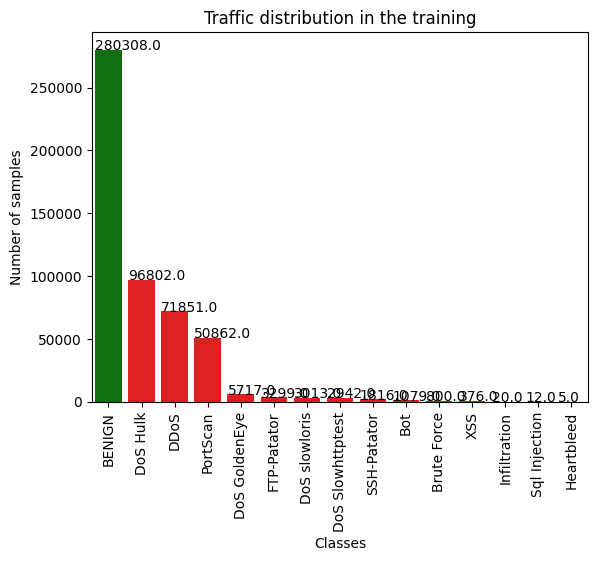

In [ ]:
order = labels_count.index
palette = {}
for key in order:
    palette[key] = "g" if key == "BENIGN" else "r"
ax = sns.countplot(x=train_labels, order=order, palette=palette)
plt.xticks(rotation="vertical")
for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x(), p.get_height()))
    
plt.title("Traffic distribution in the training")
plt.xlabel("Classes")
plt.ylabel("Number of samples")
# plt.savefig("distribution_up1.png", dpi=200, format='png', bbox_inches = "tight")
plt.show()

### OverSampling

As we can see the distribution between classes is not balanced in the training data, so I will do some OverSampling to the minority classes using SMOTE, making the dataset balanced.

In [7]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from math import ceil
import numpy as np
import pandas as pd

# Parameters
min_threshold = 0.005  # Minimum percentage threshold for resampling
min_samples_small_class = 2  # Minimum samples required for small classes

# Ensure DataFrame/Series compatibility
def ensure_dataframe(features, labels):
    if isinstance(features, np.ndarray):
        features = pd.DataFrame(features)
    if isinstance(labels, np.ndarray):
        labels = pd.Series(labels)
    return features.reset_index(drop=True), labels.reset_index(drop=True)

# Handle small classes separately
def replicate_small_classes(features, labels, min_samples=2):
    features, labels = ensure_dataframe(features, labels)
    small_classes = labels.value_counts()[labels.value_counts() < min_samples].index
    replicated_features, replicated_labels = [], []
    for cls in small_classes:
        cls_features = features[labels == cls]
        cls_labels = labels[labels == cls]
        replicated_features.append(resample(cls_features, replace=True, n_samples=min_samples, random_state=10))
        replicated_labels.append(resample(cls_labels, replace=True, n_samples=min_samples, random_state=10))
    if replicated_features:
        replicated_features = pd.concat(replicated_features, ignore_index=True)
        replicated_labels = pd.concat(replicated_labels, ignore_index=True)
    else:
        replicated_features = pd.DataFrame(columns=features.columns)
        replicated_labels = pd.Series(dtype=labels.dtype)
    return replicated_features, replicated_labels

# Main oversampling function
def oversample_data(features, labels):
    features, labels = ensure_dataframe(features, labels)
    labels_count = labels.value_counts()
    all_samples = labels_count.sum()

    # Handle classes with fewer than `min_samples_small_class`
    small_classes = labels_count[labels_count < min_samples_small_class].index
    small_features = features[labels.isin(small_classes)]
    small_labels = labels[labels.isin(small_classes)]
    replicated_features, replicated_labels = replicate_small_classes(small_features, small_labels, min_samples=min_samples_small_class)

    # Determine valid k_neighbors dynamically for SMOTE
    smallest_majority_class_size = labels_count[labels_count >= min_samples_small_class].min()
    k_neighbors = max(1, min(5, smallest_majority_class_size - 1))  # SMOTE requires k_neighbors < samples in class

    # Create SMOTE sampling strategy
    smote_strategy = {
        cls: max(count, ceil(min_threshold * all_samples))
        for cls, count in labels_count.items()
        if count >= min_samples_small_class
    }

    # Apply SMOTE
    smote = SMOTE(random_state=10, k_neighbors=k_neighbors, sampling_strategy=smote_strategy)
    try:
        over_features, over_labels = smote.fit_resample(features, labels)
    except ValueError as e:
        print(f"SMOTE failed with ValueError: {e}")
        return features, labels  # Return original data if SMOTE fails

    # Combine SMOTE results with small classes
    final_features = pd.concat([pd.DataFrame(over_features), replicated_features], ignore_index=True)
    final_labels = pd.concat([pd.Series(over_labels), replicated_labels], ignore_index=True)

    return final_features, final_labels

# Apply oversampling
over_train_features, over_train_labels = oversample_data(train_features, train_labels)
over_validation_features, over_validation_labels = oversample_data(validation_features, validation_labels)

# Print results
print("Oversampled Training Labels Distribution:")
print(over_train_labels.value_counts())
print("Oversampled Validation Labels Distribution:")
print(over_validation_labels.value_counts())


/tmp/ipykernel_65577/2569048250.py:69: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_features = pd.concat([pd.DataFrame(over_features), replicated_features], ignore_index=True)


Oversampled Training Labels Distribution:
BENIGN              280308
DoS Hulk             96802
DDoS                 71851
PortScan             50862
DoS GoldenEye         5717
FTP-Patator           3299
DoS slowloris         3013
DoS Slowhttptest      2942
SSH-Patator           2595
Brute Force           2595
Bot                   2595
XSS                   2595
Sql Injection         2595
Infiltration          2595
Heartbleed            2595
Name: count, dtype: int64
Oversampled Validation Labels Distribution:
Label
BENIGN              70305
DoS Hulk            24154
DDoS                17932
PortScan            12559
DoS GoldenEye        1420
FTP-Patator           831
DoS slowloris         757
DoS Slowhttptest      723
Brute Force           649
SSH-Patator           649
Bot                   649
XSS                   649
Infiltration          649
Sql Injection         649
Heartbleed              3
Name: count, dtype: int64


### One-hot encoding

One-hot enconding consist in turn the categorical features into numerical features. In this dataset the only categorical feature is the "Label".

Here is applyed standardization to the features and one-hot encoding to the labels. 

In [8]:
from sklearn.preprocessing import OneHotEncoder

test_labels_rshped = test_labels.values.reshape(-1,1)
over_train_labels_rshped = over_train_labels.values.reshape(-1,1)
over_validation_rshped = over_validation_labels.values.reshape(-1,1)

ohenc = OneHotEncoder()


test_labels_enc = ohenc.fit_transform(test_labels_rshped).toarray()  # one-hot encoded test set lbls
over_train_labels_enc = ohenc.fit_transform(over_train_labels_rshped).toarray()  # one-hot encoded upsampled train set lbls
over_validation_labels_enc = ohenc.fit_transform(over_validation_rshped).toarray()  # one-hot encoded upsampled train set lbls for neural nets predicting upsampled traffic

print("Shape of train features", over_train_features.shape)
print("Shape of validation features", over_validation_features.shape)
print("Shape of test features", test_features.shape)

Shape of train features (532959, 36)
Shape of validation features (132578, 36)
Shape of test features (277984, 36)


## LSTM Neural Network

2025-01-21 01:23:40.311456: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/bernardorv/CIC-IDS2017-Data-Mining/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1425s 85ms/step - accuracy: 0.8118 - loss: 0.6034 - val_accuracy: 0.9756 - val_loss: 0.0760
Epoch 2/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1608s 97ms/step - accuracy: 0.9781 - loss: 0.0648 - val_accuracy: 0.9844 - val_loss: 0.0437
Epoch 3/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1554s 93ms/step - accuracy: 0.9857 - loss: 0.0392 - val_accuracy: 0.9873 - val_loss: 0.0375
Epoch 4/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1258s 76ms/step - accuracy: 0.9886 - loss: 0.0309 - val_accuracy: 0.9896 - val_loss: 0.0307
Epoch 5/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1136s 68ms/step - accuracy: 0.9910 - loss: 0.0243 - val_accuracy: 0.9916 - val_loss: 0.0277
Epoch 6/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1054s 63ms/step - accuracy: 0.9921 - loss: 0.0213 - val_accuracy: 0.9911 - val_loss: 0.0301
Epoch 7/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1041s 62ms/step - accuracy: 0.9935 - loss: 0.0185 - val_accuracy: 0.9940 - val_loss: 0.0309
Epoch 8/50
16655/16655 ━━━━━━━━━━━━━━━━━━━━ 1057

Test Loss: 0.007266553118824959, Test Accuracy: 0.9982120990753174


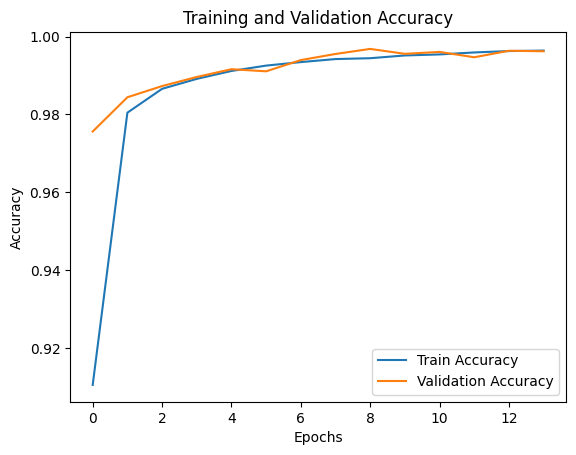

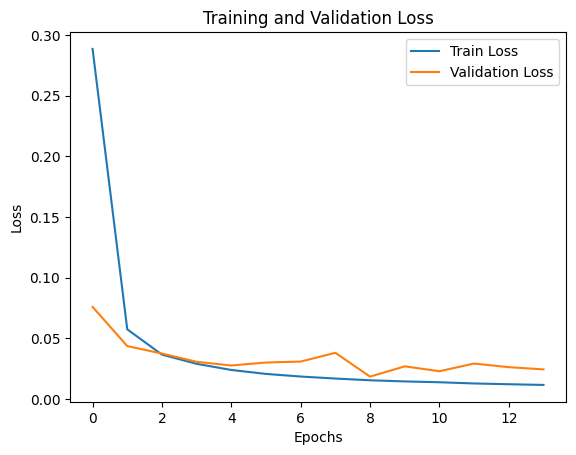

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    
    # LSTM layer
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    
    # Additional LSTM layer
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Dense layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Input shape for LSTM: (timesteps, features)
input_shape = (over_train_features.shape[1], 1)  # Features reshaped to 3D
num_classes = over_train_labels_enc.shape[1]  # Number of classes

# Reshape features for LSTM
train_features_reshaped = np.expand_dims(over_train_features, axis=-1)
validation_features_reshaped = np.expand_dims(over_validation_features, axis=-1)
test_features_reshaped = np.expand_dims(test_features, axis=-1)

# Create the LSTM model
model = create_lstm_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_features_reshaped,
    over_train_labels_enc,
    validation_data=(validation_features_reshaped, over_validation_labels_enc),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_features_reshaped, test_labels_enc)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Save the trained model
model.save('lstm_multiclass_model.keras')

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


### Evaluation

For this the split was remade.

8687/8687 ━━━━━━━━━━━━━━━━━━━━ 161s 19ms/step
Test Accuracy: 0.9982121273166801
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    150258
           1       0.87      0.93      0.90       602
           2       0.94      0.99      0.97       459
           3       1.00      1.00      1.00     38231
           4       1.00      0.99      0.99      3149
           5       1.00      1.00      1.00     51890
           6       0.99      0.99      0.99      1563
           7       0.99      0.98      0.99      1615
           8       1.00      1.00      1.00      1801
           9       1.00      0.80      0.89         5
          10       0.43      0.60      0.50        10
          11       1.00      1.00      1.00     27273
          12       0.99      0.99      0.99       926
          13       0.10      0.80      0.17         5
          14       0.73      0.94      0.82       197

    accuracy                   

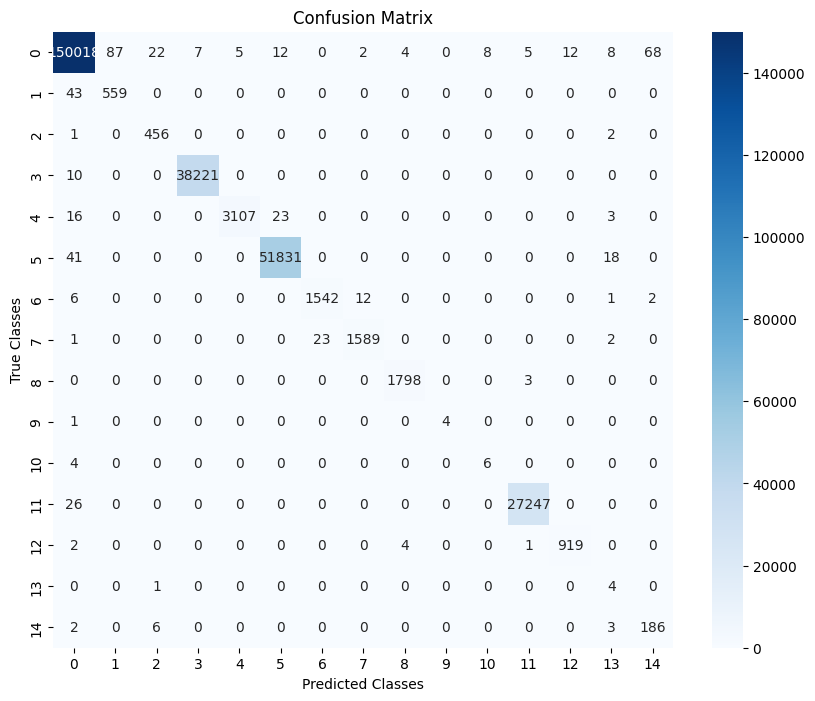

In [9]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Load the trained LSTM model
lstm_model = load_model('lstm_multiclass_model.h5')

# Prepare test data (reshape to match LSTM input requirements)
test_features_reshaped = np.expand_dims(test_features, axis=-1)  # Add a new dimension for LSTM input

# Make predictions
test_predictions = lstm_model.predict(test_features_reshaped, verbose=1)
test_predicted_classes = np.argmax(test_predictions, axis=1)  # Convert probabilities to class indices

# Calculate metrics
test_true_classes = np.argmax(test_labels_enc, axis=1)  # True class indices from one-hot encoding

# Accuracy
accuracy = accuracy_score(test_true_classes, test_predicted_classes)
print(f"Test Accuracy: {accuracy}")

# Classification report
report = classification_report(test_true_classes, test_predicted_classes)
print("Classification Report:")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(test_true_classes, test_predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

# (Optional) Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Classes")
plt.ylabel("True Classes")
plt.show()